In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

directory='../simulation_results/oriana_analysis2/'
fontsize = 14
plot_size = (10, 6)
total_time = 2000

In [6]:


def load_data():
    # Get list of relevant files first
    files = [f for f in os.listdir(directory) if f.endswith('humans_vel.csv')]
    
    # Pre-allocate list with known size
    dataframes = [None] * len(files)
    
    for i, file in enumerate(files):
        # Read the CSV
        df = pd.read_csv(os.path.join(directory, file))
        df['is_generated'] = False
        
        # If simulation ended early, calculate all new rows at once
        if df['Time'].max() < total_time:
            timestep = df['Time'].iloc[1]
            last_row = df.iloc[-1]
            
            # Calculate all new time points
            new_times = np.arange(df['Time'].max() + timestep, total_time + timestep, timestep)
            
            # Create DataFrame of new rows efficiently
            new_rows = pd.DataFrame([last_row] * len(new_times))
            new_rows['Time'] = new_times
            new_rows['is_generated'] = True
            
            # Concatenate once
            df = pd.concat([df, new_rows], ignore_index=True)
        
        # Extract metadata from filename
        df['realization'] = int(file.split('_')[2])
        df['num_humans'] = int(file.split('_')[3].strip('humans'))
        
        # Store in pre-allocated list
        dataframes[i] = df

    # Combine all dataframes at once
    df = pd.concat(dataframes, ignore_index=True)
    
    # Convert and round numeric columns
    df['Time'] = df['Time'].astype(float).round(2)
    df['zombiePercentage'] = df['zombiePercentage'].astype(float)
    df['averageVelocity'] = df['averageVelocity'].astype(float)
    
    # Filter to maximum time
    df = df[df['Time'] <= total_time]
    
    return df

def plot_mean_zombie_percentage(df):
    # Plot mean zombie percentage over time for each number of humans
    plt.figure(figsize=plot_size)
    for num_humans in df['num_humans'].unique():
        # Calculate mean and standard error of zombie percentage over time
        filtered_df = df[df['num_humans'] == num_humans]
        # Filter out generated data points to show only real simulation data
        # filtered_df = filtered_df[filtered_df['is_generated'] == False]
        grouped = filtered_df.groupby('Time')['zombiePercentage']
        mean_zombie_pct = grouped.mean()
        sem = grouped.sem()  # Standard error of the mean
        
        # Plot mean line
        plt.plot(mean_zombie_pct.index, mean_zombie_pct.values, label=f'Nh = {num_humans}')
        
        # # Add shaded error region
        plt.fill_between(mean_zombie_pct.index, 
                        mean_zombie_pct.values - sem,
                        mean_zombie_pct.values + sem,
                        alpha=0.3)  # Semi-transparent fill
        
    plt.xlabel('Tiempo (s)', fontsize=fontsize)
    plt.xlim(0, 2050)
    plt.ylabel('Porcentaje de Zombies (%)', fontsize=fontsize)
    plt.ylim(-0.05, 1.05)
    plt.legend(fontsize=fontsize)
    plt.grid(True)
    plt.show()

def plot_mean_final_time_zombie_percentage(df):
    # Plot mean final time zombie percentage for each number of humans
    # number of humans on the x axis and the mean zombie percentage at Time = max_time on the y axis
    plt.figure(figsize=plot_size)
    
    # Get max time for each realization
    max_time = df['Time'].max()
    
    # Filter data for max time only
    final_time_df = df[df['Time'] == max_time]
    
    # Calculate mean and standard error for each number of humans
    grouped = final_time_df.groupby('num_humans')['zombiePercentage']
    mean_zombie_pct = grouped.mean()
    sem = grouped.sem()
    
    # Sort by number of humans for x-axis
    x = sorted(mean_zombie_pct.index)
    y = [mean_zombie_pct[i] for i in x]
    yerr = [sem[i] for i in x]
    
    # Plot with error bars
    plt.errorbar(x, y, yerr=yerr, fmt='o-', capsize=5)
    
    plt.xlabel('Número de Inicial de Humanos', fontsize=fontsize)
    plt.ylabel('Promedio de Porcentaje de Zombies (%)', fontsize=fontsize)
    plt.ylim(-0.05, 1.05)
    plt.grid(True)
    plt.show()

def plot_zombie_percentage_for_num_humans(df, num_humans):
    # Plot all realizations for a given number of humans
    plt.figure(figsize=plot_size)
    filtered_df = df[(df['num_humans'] == num_humans)]
    for realization in filtered_df['realization'].unique():
        realization_df = filtered_df[(filtered_df['realization'] == realization)]
        plt.plot(realization_df['Time'], realization_df['zombiePercentage'])
    plt.xlabel('Tiempo (s)', fontsize=fontsize)
    plt.xlim(0, 2000)
    plt.ylabel('Porcentaje de Zombies (%)', fontsize=fontsize)
    plt.ylim(0, 1)
    plt.grid(True)
    plt.show()

def plot_mean_velocity_for_num_humans(df):
    # Plot mean velocity for num_humans
    # x axis Time; y axis mean velocity
    # plot mean velocity over time for each number of humans
    plt.figure(figsize=plot_size)
    for num_humans in df['num_humans'].unique():
        filtered_df = df[df['num_humans'] == num_humans]
        grouped = filtered_df.groupby('Time')['averageVelocity']
        mean_velocity = grouped.mean()
        plt.plot(mean_velocity.index, mean_velocity.values, label=f'Nh = {num_humans}')
    plt.xlabel('Tiempo (s)', fontsize=fontsize)
    plt.xlim(0, 2000)
    plt.ylabel('Promedio de Velocidad (m/s)', fontsize=fontsize)
    plt.ylim(0, 4.5)
    plt.legend(fontsize=fontsize)
    plt.grid(True)
    plt.show()

def plot_mean_velocity_vs_num_humans(df):
    # x axis num_humans; y axis mean velocity with Time > 250
    # Columns: Time	zombiePercentage	averageVelocity	is_generated	realization	num_humans
    plt.figure(figsize=plot_size)
    
    # Filter for Time > 250 and group by num_humans
    filtered_df = df[df['Time'] > 250]
    grouped = filtered_df.groupby('num_humans')['averageVelocity']
    
    # Calculate mean and standard error
    mean_velocity = grouped.mean()
    sem = grouped.sem()
    
    # Sort by number of humans for x-axis
    x = sorted(mean_velocity.index)
    y = [mean_velocity[i] for i in x]
    yerr = [sem[i] for i in x]
    
    # Plot with error bars
    plt.errorbar(x, y, yerr=yerr, fmt='o-', capsize=5)
    
    plt.xlabel('Número inicial de Humanos', fontsize=fontsize)
    plt.ylabel('Promedio de Velocidad (m/s)', fontsize=fontsize)
    plt.ylim(0, 4.5)
    plt.grid(True)
    plt.show()
    


In [3]:
df = load_data()
df.head()

,Time,zombiePercentage,averageVelocity,is_generated,realization,num_humans
0,0.00,0.010989,4.000000,False,195,90
1,0.05,0.010989,3.923155,False,195,90
2,0.10,0.010989,3.778120,False,195,90
3,0.15,0.010989,3.792992,False,195,90
4,0.20,0.010989,3.766667,False,195,90


In [4]:
df['num_humans'].unique()
df.dtypes

Time                float64
zombiePercentage    float64
averageVelocity     float64
is_generated           bool
realization           int64
num_humans            int64
dtype: object

# Graficos de Oriana
## tasa de zombies a lo largo del tiempo para numero de humanos variable


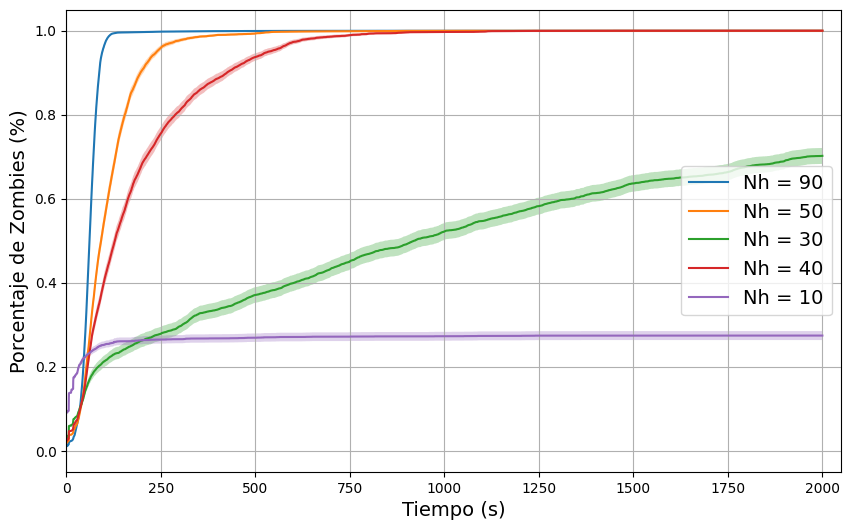

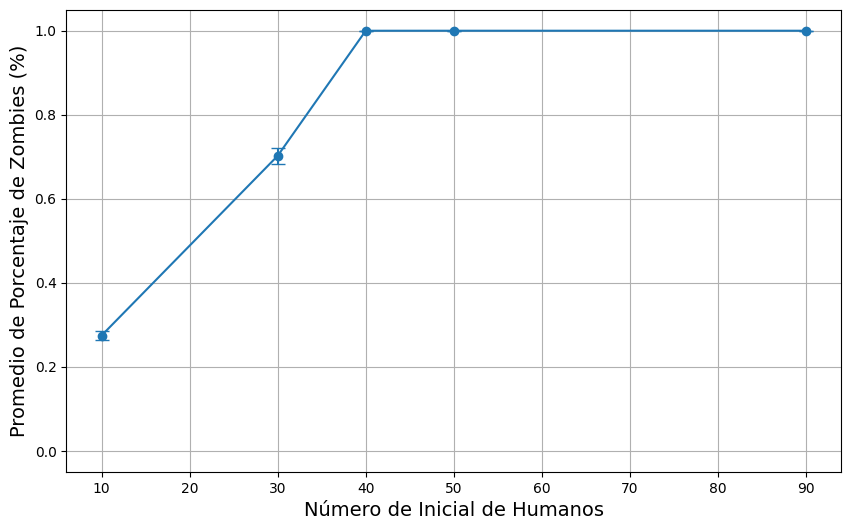

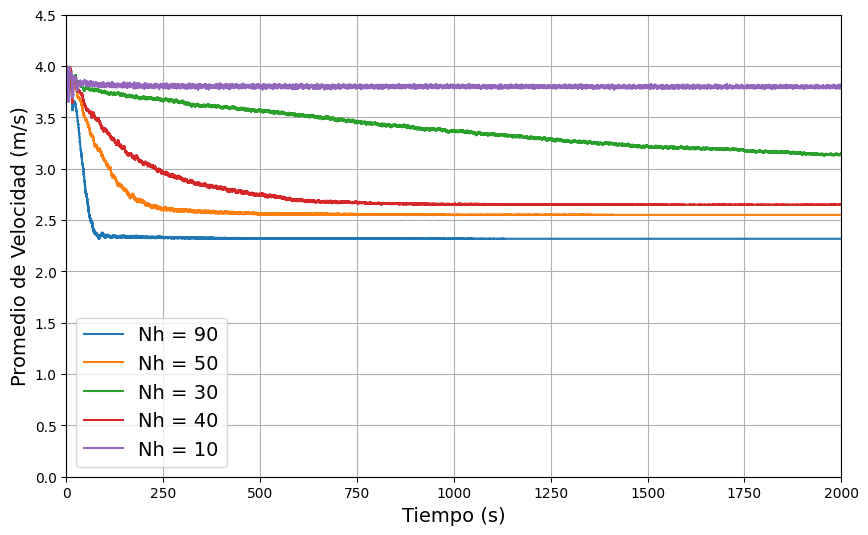

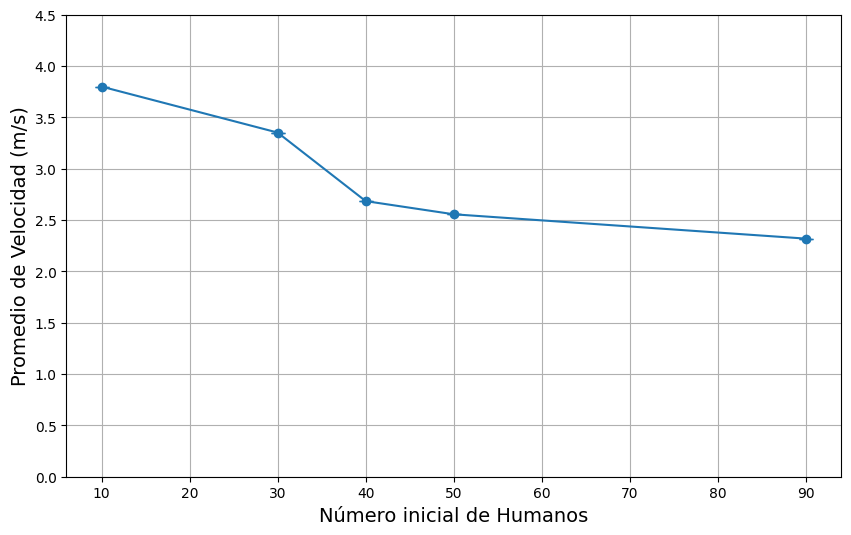

In [7]:
# 10, 30, 40, 50, 90
plot_mean_zombie_percentage(df)
plot_mean_final_time_zombie_percentage(df)
plot_mean_velocity_for_num_humans(df)
plot_mean_velocity_vs_num_humans(df)